In [13]:
# Standard library imports
import os
import time
import warnings
import random
import glob
import pickle
from pathlib import Path
from typing import Tuple, Dict, List
import numpy as np
import pandas as pd
import requests
import zipfile
import cv2
from PIL import Image
from skimage import io, transform
from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.transform import resize
from collections import Counter

# ML & utilities 
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

# Data visualization
import matplotlib.pyplot as plt
plt.ion()
# Reproducibility: set fixed seeds for python, numpy and tensorflow
SEED = 12345
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print('Seeds set to', SEED)


Seeds set to 12345


In [14]:
def load_pickle_image(file_path):
    with open(file_path, "rb") as f:         
        return pickle.load(f)                 

file_paths = []                              
for vol in range(1, 9):                      
    folder = f"archive/vol{vol:02d}"         
    file_paths += sorted(glob.glob(f"{folder}/*.pck"))  

print(f"Found {len(file_paths)} total image files")

Found 736 total image files


In [15]:
# Associate labels from metadata.csv to image file paths

meta = pd.read_csv("metadata.csv")
# Map filename -> numeric label
fn_to_label = dict(zip(meta['volumeFilename'], meta['aclDiagnosis']))
label_names = {0: 'Normal', 1: 'Torn', 2: 'Partially torn'}

# Build mapping list (file_path, numeric_label, label_name_or_None)
mapped = []
for p in file_paths:
    fname = os.path.basename(p)
    label = fn_to_label.get(fname, None)
    mapped.append((p, label, label_names.get(label) if label is not None else None))


# Summary
print("Label distribution (numeric):", Counter(l for _p, l, _n in mapped if l is not None))
print("Label distribution (names):", Counter(n for _p, l, n in mapped if n is not None))

Label distribution (numeric): Counter({0: 547, 1: 144, 2: 45})
Label distribution (names): Counter({'Normal': 547, 'Torn': 144, 'Partially torn': 45})


Preprocessing done — 490 items in 3.2s
Saved preprocessed cache to cache/preprocessed.npz
SGD-SVM acc: 0.45
SGD-LogReg acc: 0.6

Training CNN with frozen augmentations (early stopping)...
Epoch 1/50
Epoch 1/50


/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: Runtim

15/15 - 2s - 115ms/step - accuracy: 0.5292 - loss: 1.0082 - val_accuracy: 0.6667 - val_loss: 0.6857
Epoch 2/50
Epoch 2/50
15/15 - 0s - 24ms/step - accuracy: 0.5667 - loss: 0.8853 - val_accuracy: 0.6667 - val_loss: 0.6785
Epoch 3/50
15/15 - 0s - 24ms/step - accuracy: 0.5667 - loss: 0.8853 - val_accuracy: 0.6667 - val_loss: 0.6785
Epoch 3/50
15/15 - 0s - 22ms/step - accuracy: 0.5792 - loss: 0.9714 - val_accuracy: 0.6667 - val_loss: 0.6743
Epoch 4/50
15/15 - 0s - 22ms/step - accuracy: 0.5792 - loss: 0.9714 - val_accuracy: 0.6667 - val_loss: 0.6743
Epoch 4/50
15/15 - 0s - 23ms/step - accuracy: 0.5625 - loss: 0.9309 - val_accuracy: 0.6667 - val_loss: 0.6696
Epoch 5/50
15/15 - 0s - 23ms/step - accuracy: 0.5625 - loss: 0.9309 - val_accuracy: 0.6667 - val_loss: 0.6696
Epoch 5/50
15/15 - 0s - 25ms/step - accuracy: 0.5417 - loss: 0.9605 - val_accuracy: 0.6667 - val_loss: 0.6652
Epoch 6/50
15/15 - 0s - 25ms/step - accuracy: 0.5417 - loss: 0.9605 - val_accuracy: 0.6667 - val_loss: 0.6652
Epoch 6/5

Text(0.5, 1.0, 'CNN accuracy')

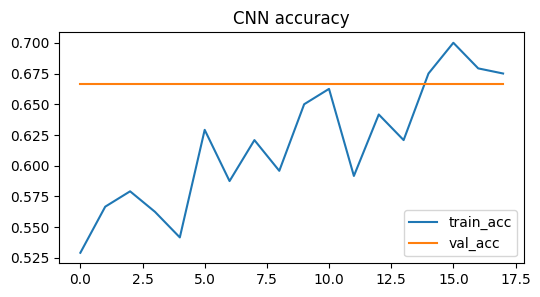

In [16]:
MAX_SAMPLES = 300
IMG_SIZE = (64, 64)
hog_params = dict(orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
AUG_PER_SAMPLE = 1

# Build per-label lists
paths_by_label = {}
for file_path, label, _name in mapped:
    if label is None:
        continue
    paths_by_label.setdefault(label, []).append(file_path)

class_labels = sorted(paths_by_label.keys())
num_classes = len(class_labels)
samples_per_class_target = max(1, MAX_SAMPLES // num_classes)

from skimage.transform import rotate as _rotate

def augment_slice_deterministic(img, rng):
    a = img.copy()
    if rng.random() < 0.5:
        a = np.fliplr(a)
    ang = rng.uniform(-10, 10)
    a = _rotate(a, ang, mode='edge', preserve_range=True)
    return a

# Prepare cache
cache_dir = Path('cache')
cache_dir.mkdir(exist_ok=True)
cache_path = cache_dir / 'preprocessed.npz'
rng = random.Random(SEED)
np_rng = np.random.RandomState(SEED)

if cache_path.exists():
    print('Loading preprocessed data from', cache_path)
    data = np.load(cache_path, allow_pickle=True)
    X_hog = data['X_hog']
    X_images = data['X_images']
    y_labels = data['y_labels']
else:
    hog_features_list = []
    image_tensors_list = []
    labels_list = []
    t_start = time.time()
    for label in class_labels:
        file_paths_for_label = paths_by_label[label]
        if len(file_paths_for_label) == 0:
            continue
        n_take = min(len(file_paths_for_label), samples_per_class_target)
        # deterministic sampling
        if n_take <= len(file_paths_for_label):
            chosen = rng.sample(list(file_paths_for_label), n_take)
        else:
            chosen = [rng.choice(list(file_paths_for_label)) for _ in range(n_take)]
        for chosen_path in chosen:
            volume = load_pickle_image(chosen_path)
            volume_arr = np.asarray(volume)
            mid_slice = volume_arr[volume_arr.shape[0] // 2] if volume_arr.ndim == 3 else volume_arr
            if mid_slice.ndim == 3:
                mid_slice = rgb2gray(mid_slice)
            slice_resized = resize(mid_slice, IMG_SIZE, anti_aliasing=True)
            hog_descriptor = hog((slice_resized * 255).astype(np.uint8), orientations=hog_params['orientations'], pixels_per_cell=hog_params['pixels_per_cell'], cells_per_block=hog_params['cells_per_block'], visualize=False, feature_vector=True)
            hog_features_list.append(hog_descriptor)
            image_tensors_list.append(np.expand_dims(slice_resized.astype(np.float32), -1))
            labels_list.append(label)
            # deterministic augmentations
            for _ in range(AUG_PER_SAMPLE):
                a = augment_slice_deterministic(slice_resized, rng)
                hog_descriptor_aug = hog((a * 255).astype(np.uint8), orientations=hog_params['orientations'], pixels_per_cell=hog_params['pixels_per_cell'], cells_per_block=hog_params['cells_per_block'], visualize=False, feature_vector=True)
                hog_features_list.append(hog_descriptor_aug)
                image_tensors_list.append(np.expand_dims(a.astype(np.float32), -1))
                labels_list.append(label)
    t_end = time.time()
    print(f'Preprocessing done — {len(hog_features_list)} items in {t_end-t_start:.1f}s')
    # Truncate to MAX_SAMPLES deterministically (keep first N)
    if len(hog_features_list) > MAX_SAMPLES:
        hog_features_list = hog_features_list[:MAX_SAMPLES]
        image_tensors_list = image_tensors_list[:MAX_SAMPLES]
        labels_list = labels_list[:MAX_SAMPLES]
    X_hog = np.vstack(hog_features_list)
    y_labels = np.array(labels_list)
    X_images = np.stack(image_tensors_list)
    # Save deterministic preprocessed arrays (includes frozen augmentations)
    np.savez_compressed(cache_path, X_hog=X_hog, X_images=X_images, y_labels=y_labels)
    print('Saved preprocessed cache to', cache_path)

# Create one fixed train/test split (re-used by all models). Use SEED for determinism
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(X_hog, y_labels, test_size=0.2, stratify=y_labels, random_state=SEED)
# Build matching image train/val split indices deterministically
idx_all = np.arange(len(y_labels))
_, idx_test = train_test_split(idx_all, test_size=0.2, stratify=y_labels, random_state=SEED)
idx_train = np.setdiff1d(idx_all, idx_test)
X_images_train = X_images[idx_train]
X_images_val = X_images[idx_test]
Y_images_train = y_labels[idx_train]
y_images_train = y_labels[idx_train]
y_images_val = y_labels[idx_test]

# Train simple linear SGD models on HOG (deterministic)
epochs = 10
sgd_svm = SGDClassifier(loss='hinge', random_state=SEED)
for epoch in range(epochs):
    sgd_svm.partial_fit(X_hog_train, y_hog_train, classes=np.unique(y_hog_train))

sgd_logr = SGDClassifier(loss='log_loss', random_state=SEED)
for epoch in range(epochs):
    sgd_logr.partial_fit(X_hog_train, y_hog_train, classes=np.unique(y_hog_train))

print('SGD-SVM acc:', accuracy_score(y_hog_test, sgd_svm.predict(X_hog_test)))
print('SGD-LogReg acc:', accuracy_score(y_hog_test, sgd_logr.predict(X_hog_test)))

# CNN training with frozen augmentations (precomputed) and a robust architecture
n_classes = len(np.unique(y_labels))
# Ensure images are in 0..1
X_images_train = np.clip(X_images_train, 0.0, 1.0)
X_images_val = np.clip(X_images_val, 0.0, 1.0)

model = models.Sequential([
    layers.Input(shape=X_images_train.shape[1:]),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
print('\nTraining CNN with frozen augmentations (early stopping)...')
history = model.fit(X_images_train, y_images_train, epochs=50, batch_size=16, validation_data=(X_images_val, y_images_val), callbacks=callbacks, verbose=2)
loss, acc = model.evaluate(X_images_val, y_images_val, verbose=0)
print('\nCNN validation acc:', acc)
# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('CNN accuracy')
